In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
df_test = pd.read_csv('data/loan_sanction_test.csv')
df_train = pd.read_csv('data/loan_sanction_train.csv')

In [3]:
df_train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
def check_df(dataframe):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(5))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(df_train)

##################### Shape #####################
(614, 13)
##################### Types #####################
Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object
##################### Head #####################
    Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001002   Male      No          0      Graduate            No   
1  LP001003   Male     Yes          1      Graduate            No   
2  LP001005   Male     Yes          0      Graduate           Yes   
3  LP001006   Male     Yes          0  Not Graduate            No   
4  LP001008   Male      No          0      Graduate            No   

   ApplicantIncome  CoapplicantInco

## Data cleaning

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

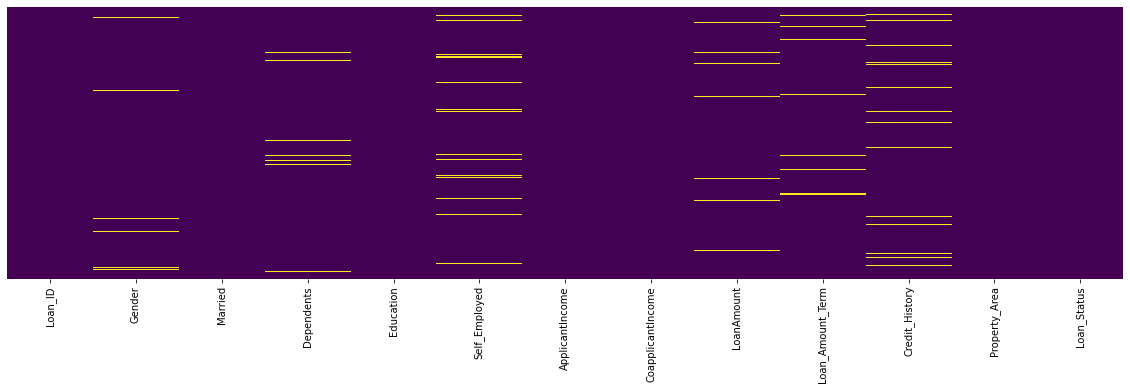

In [5]:
#plotout columns with missing data
plt.figure(figsize=(20,5))
sns.heatmap(df_train.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.plot

In [6]:
#column names to lower case
df_train.columns = df_train.columns.str.lower()
df_train.columns

Index(['loan_id', 'gender', 'married', 'dependents', 'education',
       'self_employed', 'applicantincome', 'coapplicantincome', 'loanamount',
       'loan_amount_term', 'credit_history', 'property_area', 'loan_status'],
      dtype='object')

In [7]:
df_train.self_employed.value_counts()

No     500
Yes     82
Name: self_employed, dtype: int64

In [8]:
df_train.credit_history.value_counts()

1.0    475
0.0     89
Name: credit_history, dtype: int64

In [9]:
df_train.loan_amount_term.value_counts()

360.0    512
180.0     44
480.0     15
300.0     13
240.0      4
84.0       4
120.0      3
60.0       2
36.0       2
12.0       1
Name: loan_amount_term, dtype: int64

In [10]:
df_train.loanamount.value_counts()

120.0    20
110.0    17
100.0    15
160.0    12
187.0    12
         ..
240.0     1
214.0     1
59.0      1
166.0     1
253.0     1
Name: loanamount, Length: 203, dtype: int64

In [11]:
df_train.dependents.value_counts()

0     345
1     102
2     101
3+     51
Name: dependents, dtype: int64

In [12]:
df_train.gender.value_counts()

Male      489
Female    112
Name: gender, dtype: int64

In [13]:
#Find the total number of missing values from the entire dataset
df_train.isnull().sum().sum()

149

#### How many missing data points do we have?

###### Ok, now we know that we do have some missing values. Let's see how many we have in each column.

In [14]:
# get the number of missing data points per column
missing_values_count = df_train.isnull().sum()
# look at the # of missing points in the first ten columns
missing_values_count[0:14]

loan_id               0
gender               13
married               3
dependents           15
education             0
self_employed        32
applicantincome       0
coapplicantincome     0
loanamount           22
loan_amount_term     14
credit_history       50
property_area         0
loan_status           0
dtype: int64

In [15]:
# how many total missing values do we have?
total_cells = np.product(df_train.shape)
total_missing = missing_values_count.sum()
# percent of data that is missing
percent_missing = (total_missing / total_cells) * 100
print(f"{percent_missing:.2f}%")

1.87%


### Filling out missing data
For categorical columns, we shall use mode to fillout all missing values

In [16]:
#Replace the missing values for categorical columns with mode
df_train['gender'] = df_train['gender'].fillna(df_train['gender'].mode()[0])
df_train['married'] = df_train['married'].fillna(df_train['married'].mode()[0])
df_train['self_employed'] = df_train['self_employed'].fillna(df_train['self_employed'].mode()[0])
df_train.isnull().sum()

loan_id               0
gender                0
married               0
dependents           15
education             0
self_employed         0
applicantincome       0
coapplicantincome     0
loanamount           22
loan_amount_term     14
credit_history       50
property_area         0
loan_status           0
dtype: int64

For numerical columns, we have to first do outlier analysis. for columns with outliers we use medium of the series to fill out missing data and for data with no outliers we use mean

In [17]:
#Checking for outliers in loan_amount_term column
def detect_outliers(data):
    quartile_1, quartile_3 = np.percentile(data, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = [x for x in data if x < lower_bound or x > upper_bound]
    return outliers

In [18]:
print(detect_outliers(df_train['loan_amount_term']))

[]


In [19]:
df_train.loan_amount_term.value_counts()

360.0    512
180.0     44
480.0     15
300.0     13
240.0      4
84.0       4
120.0      3
60.0       2
36.0       2
12.0       1
Name: loan_amount_term, dtype: int64

our function above returns no outliers, but by observation we have 480 which is isolated from the rest of the values, so not to tamper alot with data integrity we shall use medium to fill missing data

In [20]:
#our function above returns no outliers, but by observation we have 480 which is isolated from the rest of the values, so not to tamper alot with data integrity we shall use medium to fill missing data
df_train['loan_amount_term']= df_train['loan_amount_term'].fillna(df_train['loan_amount_term'].median())

In [21]:
df_train.isnull().sum()

loan_id               0
gender                0
married               0
dependents           15
education             0
self_employed         0
applicantincome       0
coapplicantincome     0
loanamount           22
loan_amount_term      0
credit_history       50
property_area         0
loan_status           0
dtype: int64

In [22]:
#Checking for outliers in credit_history column
print(detect_outliers(df_train['credit_history']))

[]


In [23]:
#Checking for outliers in loanamount column
print(detect_outliers(df_train['loanamount']))

[]


We are using mean to fillout missing values since we see no outliers

In [24]:
#Replace the missing values for numerical columns with mean
df_train['loanamount'] = df_train['loanamount'].fillna(df_train['loanamount'].mean())
df_train['credit_history'] = df_train['credit_history'].fillna(df_train['credit_history'].mean())

In [25]:
df_train.isnull().sum()

loan_id               0
gender                0
married               0
dependents           15
education             0
self_employed         0
applicantincome       0
coapplicantincome     0
loanamount            0
loan_amount_term      0
credit_history        0
property_area         0
loan_status           0
dtype: int64

In [26]:
#Replace the missing value with '0' using 'fiilna' method
df_train['dependents'] = df_train['dependents'].fillna(0)
df_train['dependents'].isnull().sum()

0

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

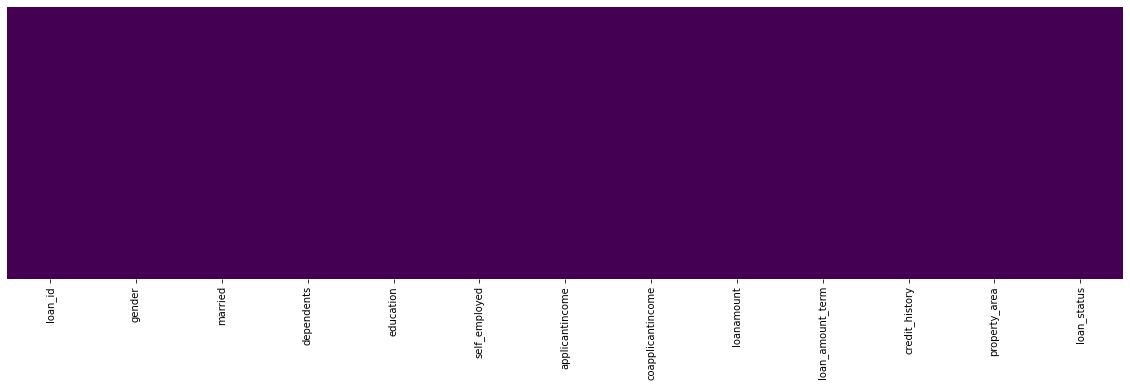

In [27]:
#plotout columns with missing data
plt.figure(figsize=(20,5))
sns.heatmap(df_train.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.plot

In [28]:
df_train.columns

Index(['loan_id', 'gender', 'married', 'dependents', 'education',
       'self_employed', 'applicantincome', 'coapplicantincome', 'loanamount',
       'loan_amount_term', 'credit_history', 'property_area', 'loan_status'],
      dtype='object')

In [29]:
df_train.property_area.unique()

array(['Urban', 'Rural', 'Semiurban'], dtype=object)

In [30]:
df_train.head()

,loan_id,gender,married,dependents,education,self_employed,applicantincome,coapplicantincome,loanamount,loan_amount_term,credit_history,property_area,loan_status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,146.412162,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.000000,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.000000,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.000000,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.000000,360.0,1.0,Urban,Y


In [31]:
df_train.loan_status.unique()

array(['Y', 'N'], dtype=object)

<AxesSubplot:title={'center':'applicantincome'}, xlabel='loan_status'>

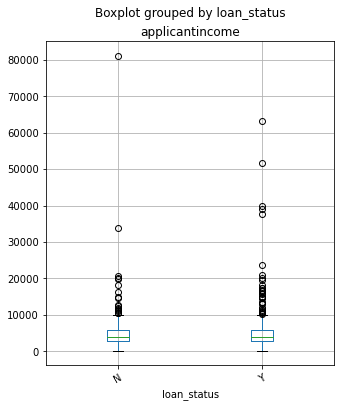

In [32]:
df_train.boxplot('applicantincome','loan_status',rot = 30,figsize=(5,6))


In [33]:
#getting the actual number of distinct values.
print(df_train['loan_status'].value_counts().count())

2


#### Encoding loan status using  scikit-learn's LabelEncode

In [35]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
lb_make = LabelEncoder()
cat_df_flights_sklearn['loan_status'] = lb_make.fit_transform(cat_df_flights['carrier'])